## Pose Estimation -- Humans and Animals
#### Thomas Reynolds

In [13]:
from matplotlib import image
from matplotlib import patches
from matplotlib import pyplot as plt
import json
import pycocotools
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
import albumentations as A

# https://github.com/pytorch/vision/tree/main/references/detection
import sys
sys.path.append('./dependencies')
import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate

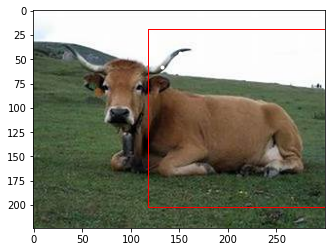

In [17]:
# Plot the keypoints and bounding box for one image
test_img = 4000

# Read in keypoints data
with open('data/annotations.json') as f:
    img_info = json.load(f)

# Get an image
img_name = 'data/images/' + img_info['images'][str(test_img)]
test_image = image.imread(img_name)

# Get the keypoints for the image
key_data = img_info['annotations'][test_img-1]

# Create figure and axes
fig, ax = plt.subplots()

# Annotate over image
for point in key_data['keypoints']:
    if point[2] != 0:
        # do stuff
        plt.plot(point[0], point[1], marker='.', color="white")

plt.imshow(test_image)

# Create a Rectangle patch
rect = patches.Rectangle((key_data['bbox'][0], key_data['bbox'][1]), key_data['bbox'][2] - key_data['bbox'][0], key_data['bbox'][3] - key_data['bbox'][1], linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [2]:
def train_transform():
    return A.Compose([
        A.Sequential([
            A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=1), # Random change of brightness & contrast
        ], p=1)
    ],
    keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more at https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

In [3]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])

        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)        
        
        with open(annotations_path) as f:
            data = json.load(f)
            bboxes_original = data['bboxes']
            keypoints_original = data['keypoints']
            
            # All objects are glue tubes
            bboxes_labels_original = ['Detected Object' for _ in bboxes_original]            


        img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
        
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64) # all objects are glue tubes
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)        
        img = F.to_tensor(img)
        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64) # all objects are glue tubes
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)

In [4]:
dataset = ClassDataset('data', transform=train_transform(), demo=True)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)

print("Original targets:\n", batch[3], "\n\n")
print("Transformed targets:\n", batch[1])

Original targets:
 ({'boxes': tensor([[170., 168., 344., 368.]]), 'labels': tensor([1]), 'image_id': tensor([2135]), 'area': tensor([34800.]), 'iscrowd': tensor([0]), 'keypoints': tensor([[[325., 196.,   1.],
         [294., 195.,   1.],
         [311., 214.,   1.],
         [326., 179.,   1.],
         [290., 183.,   1.],
         [299., 312.,   1.],
         [275., 317.,   1.],
         [177., 291.,   1.],
         [196., 306.,   1.],
         [299., 310.,   1.],
         [278., 317.,   1.],
         [175., 294.,   1.],
         [192., 313.,   1.],
         [301., 354.,   1.],
         [282., 361.,   1.],
         [187., 338.,   1.],
         [210., 355.,   1.],
         [309., 233.,   1.],
         [265., 214.,   1.],
         [183., 219.,   1.]]])},) 


Transformed targets:
 ({'boxes': tensor([[170., 168., 344., 368.]]), 'labels': tensor([1]), 'image_id': tensor([2135]), 'area': tensor([34800.]), 'iscrowd': tensor([0]), 'keypoints': tensor([[[325., 196.,   1.],
         [294., 195.

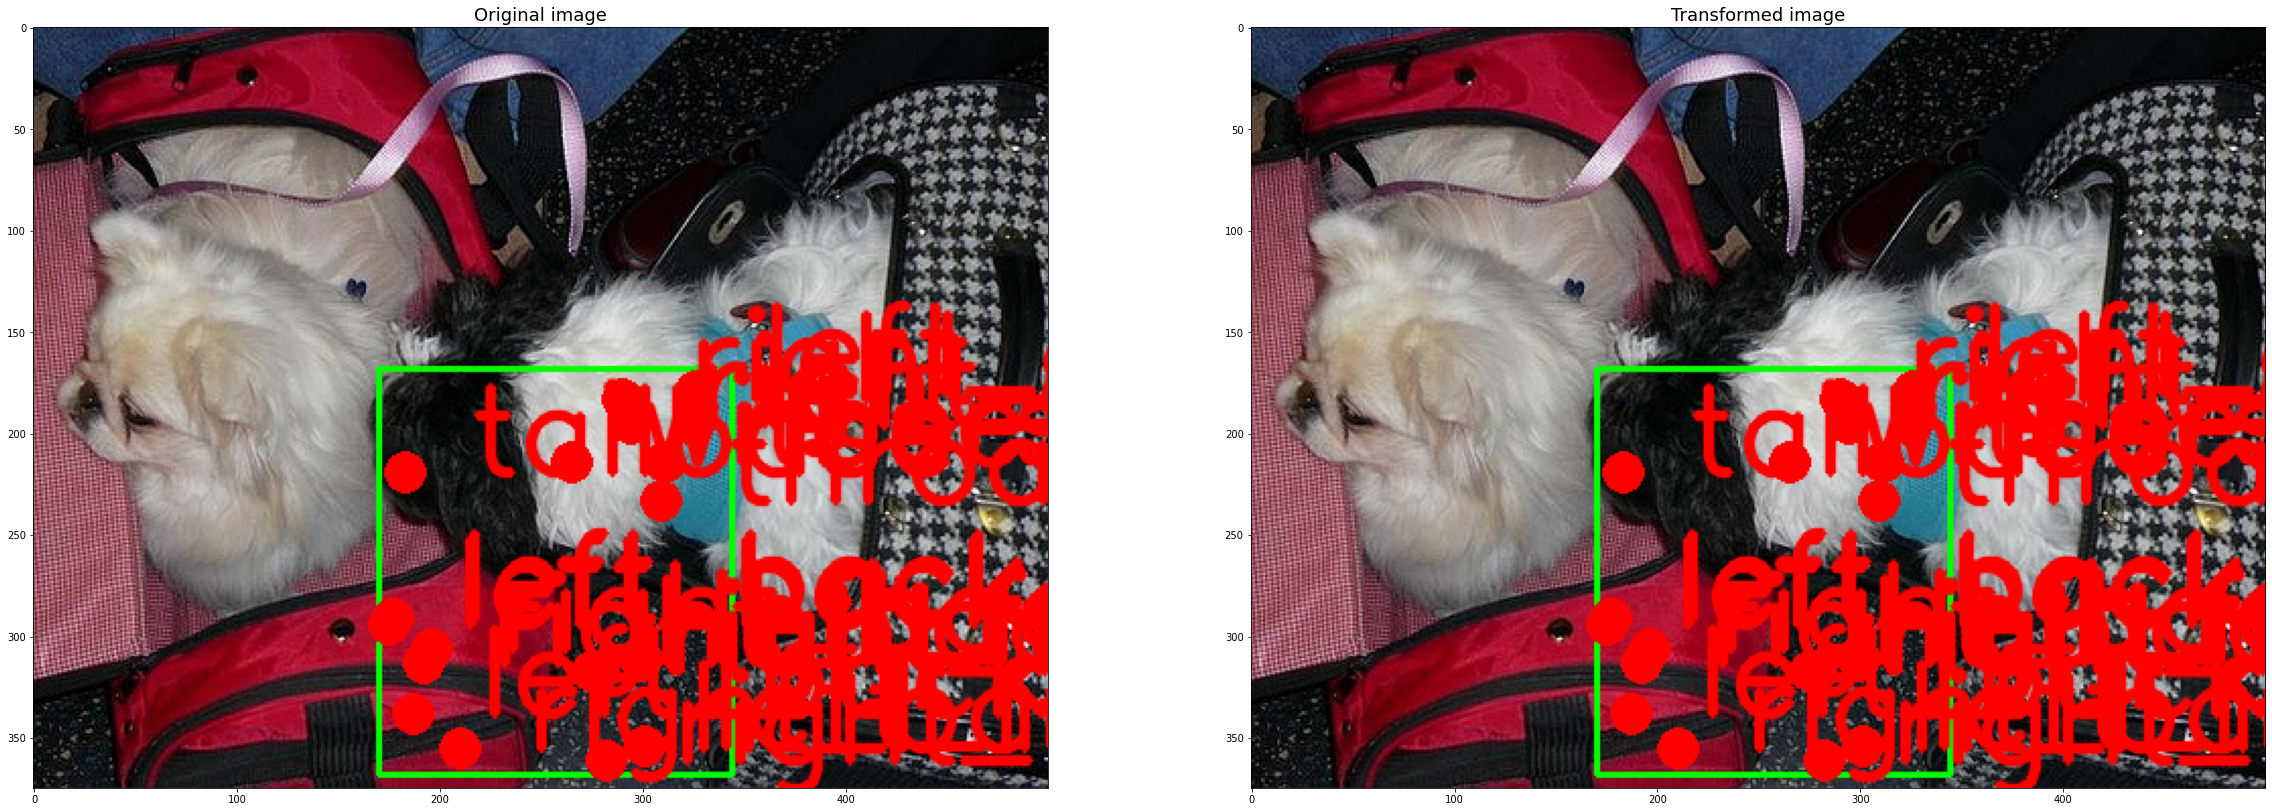

In [11]:
# Show some images

keypoints_classes_ids2names = {0:"left_eye", 1:"right_eye", 2:"nose", 3:"left_ear", 4:"right_ear", 5:"left_front_elbow",
    6:"right_front_elbow", 7:"left_back_elbow", 8:"right_back_elbow", 9:"left_front_knee", 10:"right_front_knee",
    11:"left_back_knee", 12:"right_back_knee", 13:"left_front_paw", 14:"right_front_paw", 15:"left_back_paw",
    16:"right_back_paw", 17:"throat", 18:"withers", 19:"tailbase"}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(image.copy(), tuple(kp), 5, (255,0,0), 10)
            image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 10)
                image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)
        
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

In [4]:
# Get test and train sets
images = img_info['images']
train_size = int(0.8 * len(images))
test_size = len(images) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(images, [train_size, test_size])

print("Train images: ", len(train_dataset))
print("Test images: ", len(test_dataset))

Train images:  3686
Test images:  922


In [5]:
class Hourglass(torch.nn.Module):
  def __init__(self, input_dim, output_dim, kernel_size=3, stride = 1, bn = False, relu = True):
    super(Hourglass, self).__init__()
    self.inp_dim = input_dim
    self.conv = torch.nn.Conv2d(input_dim, output_dim, kernel_size, stride, padding=(kernel_size-1)//2, bias=True)
    self.relu = None
    self.bn = None
    if relu:
      self.relu = torch.nn.ReLU()
    if bn:
      self.bn = torch.nn.BatchNorm2d(output_dim)      
  
  def forward(self, x): 
    assert x.size()[1] == self.inp_dim, "{} {}".format(x.size()[1], self.inp_dim)
    x = self.conv(x)
    if self.bn is not None:
        x = self.bn(x)
    if self.relu is not None:
        x = self.relu(x)
    return x